# Variant 2-15 Normal vs non-parametric Bayes classifier

## Read data

In [14]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
data = pd.read_csv('lab2/data_ml_v2-15.csv') # load the data
X = data.iloc[:, :-1].values # extract the features
y = data.iloc[:, -1].values # extract the labels

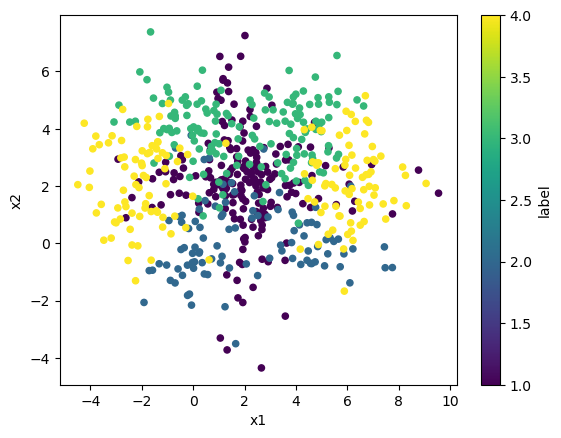

In [15]:
data.plot.scatter(x='x1', y='x2', c='label', colormap='viridis');

## 1. Оценить ковариационные матрицы обучающих данных для каждого класса при различных предположениях: 

а) ковариационные матрицы всех классов равные, скалярные; 

б) равные, диагональные; 

в) различные, скалярные; 

г) различные, диагональные; 

д) равные; 

е) различные.

**Визуализировать матрицы для каждого случая.**

In [16]:
def plot_cov_matrixes(cov_matrixes: np.ndarray, title: str):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(4):
        ax = axs[i//2, i%2]
        im = ax.imshow(cov_matrixes[i])
        ax.set_title(f'Covariance Matrix of Class {i+1}')
        fig.colorbar(im, ax=ax)
        # disable the ticks
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # add values to the plot
        # for i in range(2):
        #     for j in range(2):
        #         text = ax.text(j, i, np.round(cov_matrixes[i, j], 2),
        #                     ha="center", va="center", color="r", fontsize=12)
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [17]:
# разделение на обучающую и тестовую выборки
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_scores = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}
test_scores = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

train_preds = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}
test_preds = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

# train_acc = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}
# test_acc = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    
    # оценка априорных вероятностей
    class_probs = np.ones((4,)) / 4
    
    # оценка ковариационных матриц
    cov_matrices = {'a':[],'b':[],'c':[],'d':[],'e':[],'f':[]}
    for i in range(4):
        class_data = X_train[y_train == i+1]
        
        # а) все ковариационные матрицы равны и скалярны
        cov_matrices['a'].append(np.cov(class_data.T))
        # б) все ковариационные матрицы равны и диагональны
        cov_matrices['b'].append(np.diag(np.var(class_data, axis=0)))
        # в) различные ковариационные матрицы и скалярные
        cov_matrices['c'].append(np.cov(class_data.T))
        # г) различные ковариационные матрицы и диагональные
        cov_matrices['d'].append(np.diag(np.var(class_data, axis=0)))
        # д) все ковариационные матрицы равны
        cov_matrices['e'].append(np.cov(X_train.T))
        # е) различные ковариационные матрицы
        cov_matrices['f'].append(np.cov(class_data.T))
    
    # расчет матрицы обратных ковариационных матриц
    # inv_cov_matrices = {'a':[],'b':[],'c':[],'d':[],'e':[],'f':[]}
    # for key in cov_matrices.keys():
    #     inv_cov_matrices[key].extend([np.linalg.inv(cov_matrix) for cov_matrix in cov_matrices[key]])
    
    # обучение байесовского классификатора
    def bayes_classifier(x, cov_matrices):
        probs = np.zeros((4,))
        for i in range(4):
            probs[i] = multivariate_normal.pdf(x, mean=np.mean(X_train[y_train == i+1], axis=0), cov=cov_matrices[i], allow_singular=True)
        posterior_probs = probs * class_probs / np.sum(probs * class_probs)
        return posterior_probs
    
    # расчет классификационных очков
    for key in cov_matrices.keys():
        train_scores[key].append(np.mean([np.argmax(bayes_classifier(x, cov_matrices[key])) + 1 == y_train[i] for i, x in enumerate(X_train)]))
        test_scores[key].append(np.mean([np.argmax(bayes_classifier(x, cov_matrices[key])) + 1 == y_test[i] for i, x in enumerate(X_test)]))

        
for key in cov_matrices.keys():
    print(f'Train scores for {key}: {train_scores[key]}')
    print(f'Mean train score for {key}: {np.mean(train_scores[key])}')
    print(f'Test scores for {key}: {test_scores[key]}')
    print(f'Mean test score for {key}: {np.mean(test_scores[key])}')


Train scores for a: [0.6479166666666667, 0.6333333333333333, 0.6479166666666667, 0.66875, 0.6270833333333333]
Mean train score for a: 0.6449999999999999
Test scores for a: [0.6083333333333333, 0.6583333333333333, 0.675, 0.5583333333333333, 0.7]
Mean test score for a: 0.64
Train scores for b: [0.6520833333333333, 0.6395833333333333, 0.6395833333333333, 0.6666666666666666, 0.6291666666666667]
Mean train score for b: 0.6454166666666665
Test scores for b: [0.6083333333333333, 0.6583333333333333, 0.675, 0.5666666666666667, 0.6916666666666667]
Mean test score for b: 0.64
Train scores for c: [0.6479166666666667, 0.6333333333333333, 0.6479166666666667, 0.66875, 0.6270833333333333]
Mean train score for c: 0.6449999999999999
Test scores for c: [0.6083333333333333, 0.6583333333333333, 0.675, 0.5583333333333333, 0.7]
Mean test score for c: 0.64
Train scores for d: [0.6520833333333333, 0.6395833333333333, 0.6395833333333333, 0.6666666666666666, 0.6291666666666667]
Mean train score for d: 0.64541666

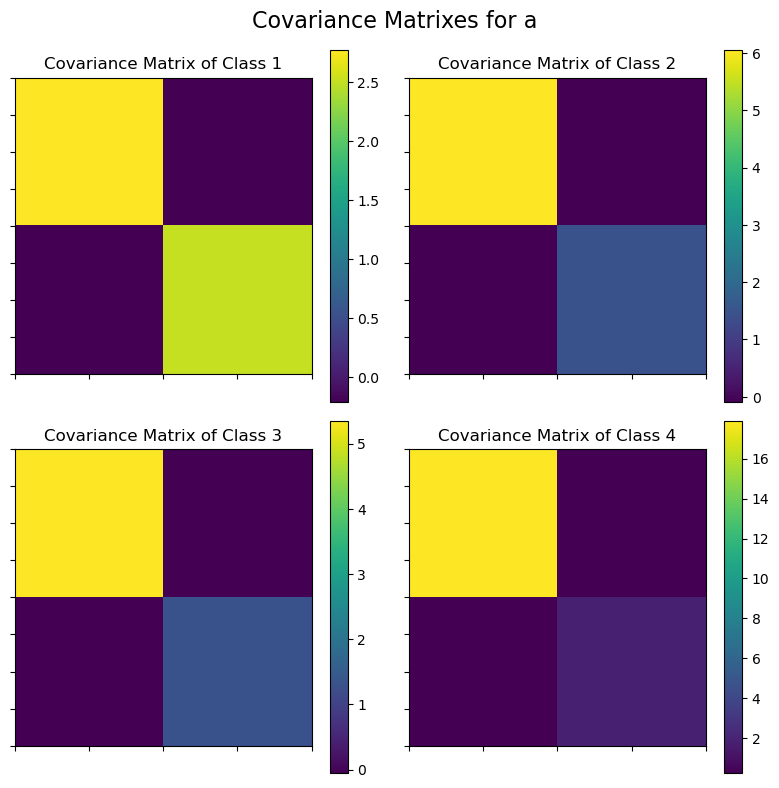

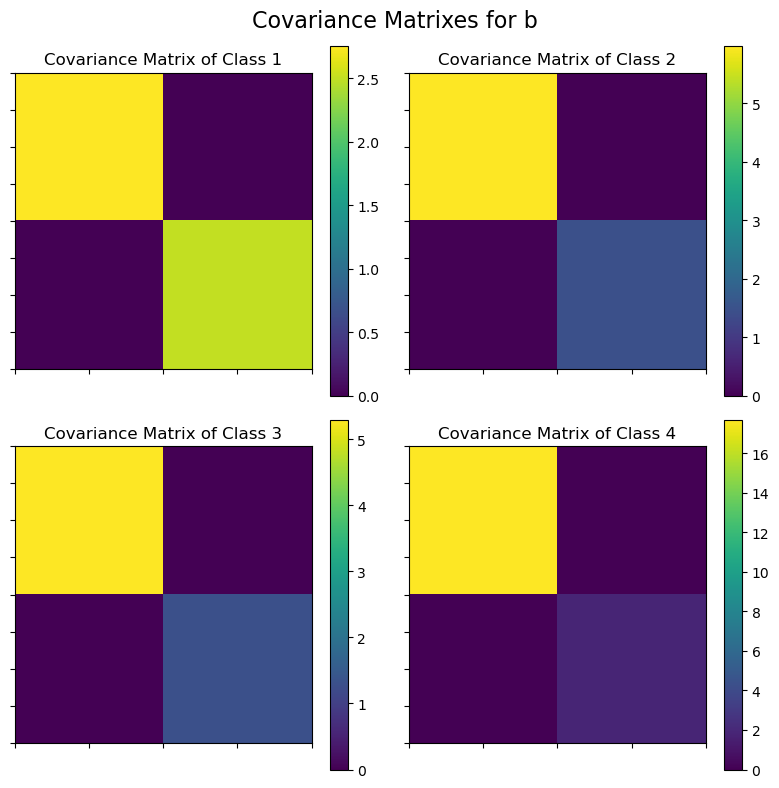

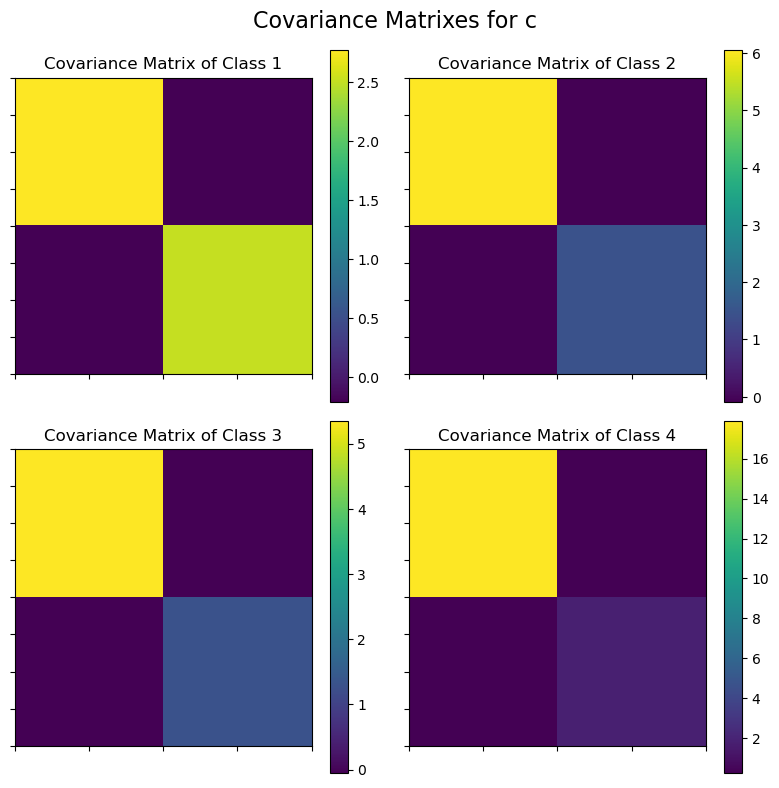

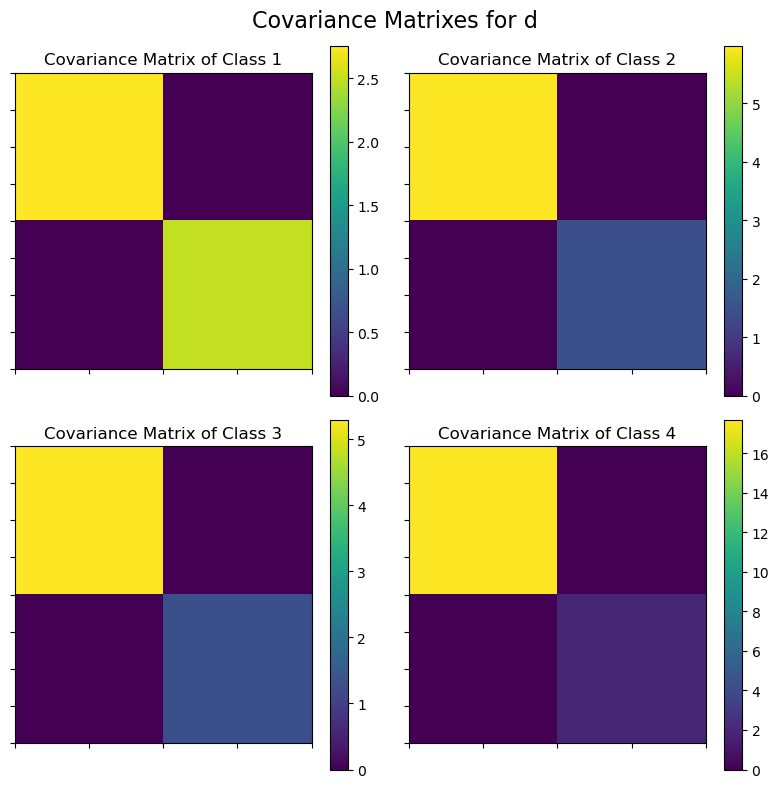

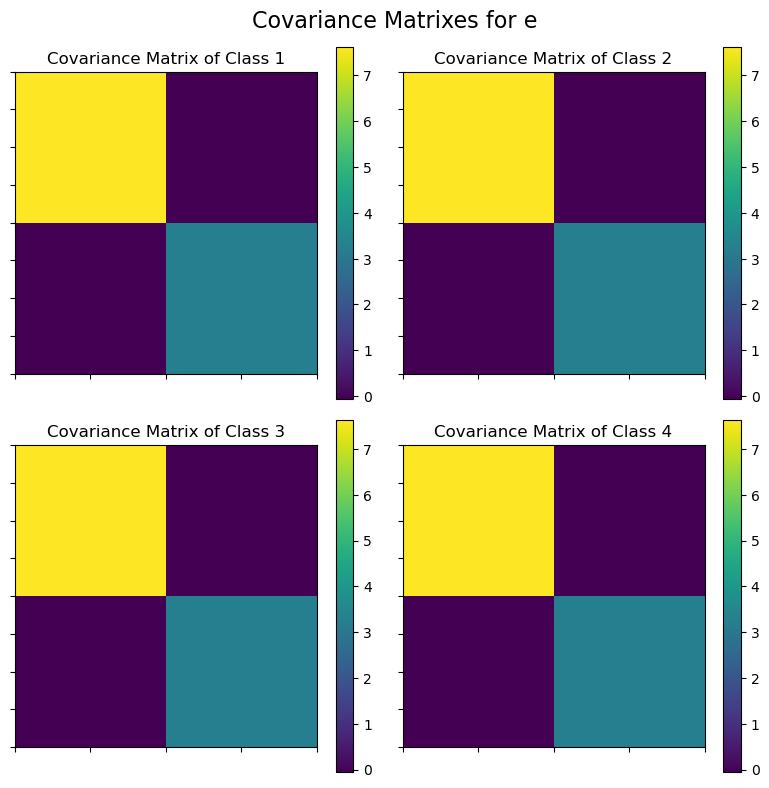

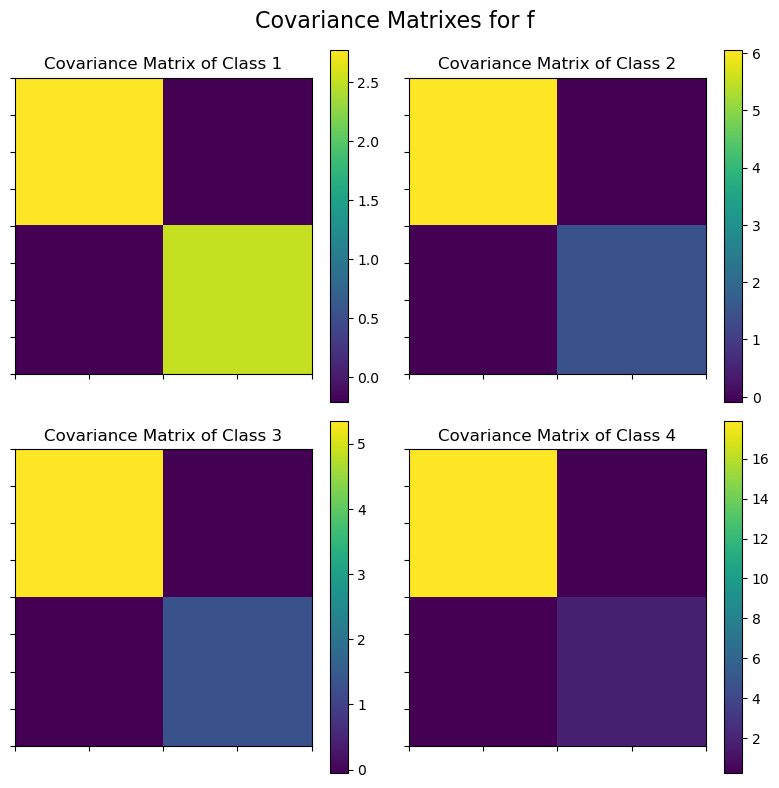

In [18]:
for key in cov_matrices.keys():
    plot_cov_matrixes(cov_matrices[key], f'Covariance Matrixes for {key}')